In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name

In [3]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]
df= pd.read_csv(data_dir+'/cl3d.csv', usecols=columns, low_memory=True)

FileNotFoundError: [Errno 2] File b'/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/preprocessing/200PU/cl3d.csv' does not exist: b'/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/preprocessing/200PU/cl3d.csv'

In [4]:
df['genpart_pt'][df['sample']=='PU'].min()

NameError: name 'df' is not defined

In [ ]:
for samp in ['elec', 'pion', 'PU']:
    print(samp,len(df[df['sample']==samp]))

# Config

In [ ]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
bkg='PU' # 'pions' or 'PU'
#feature_set=5 # 1: minimal high level set 2: inclusive high level 3: set2 +layer 4: transverse + layers
#5:all high level for jb 6: set 3 but layer_pt/cl3d_pt
opti=False
res_dir=workdir+'/comparison_21Jun'
os.makedirs(res_dir, exist_ok=True)

In [ ]:
%%time

def tolist(x):
    if x.matches==True:
        x.test=x.layer[1:-1].split(',')
    else: x.test=np.nan
    return x.test
print(len(df))

#cut on pt gen level for electrons and pions
sel=((df['genpart_pt']>genptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]

#cut on cl3d_pt for elec and pions
sel=((df['cl3d_pt'] > cl3dptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]
print('elec and pions pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))

#cut on cl3d_pt for PU
sel=((df_cut['cl3d_pt'] > PU_cut) & (df_cut['sample']=='PU')) | (df_cut['sample']!='PU')
df_cut=df_cut[sel]
print('PU pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))

#cut on hgcal eta acceptance
sel=np.abs(df_cut['genpart_exeta'])>etamin
df_cut=df_cut[sel]
print('min eta cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
sel=np.abs(df_cut['genpart_exeta'])<etamax
df_cut=df_cut[sel]
print('max eta cut : ',len(df_cut)), len(df_cut[df_cut['sample']=='elec'])
#drop incomplete events
df_cut.dropna(inplace=True)
print('drpna : ', len(df_cut))

#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))


#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]
for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")
"""if feature_set in [6]:
    for n in range(n_layers):
        print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
        df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
        df_cut['layer_{}'.format(n)] = df_cut['layer_{}'.format(n)]/df_cut['cl3d_pt']
        layer_columns.append('layer_{}'.format(n))
    print("done layering")"""



In [ ]:
%%time
# build new vars

#abseta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 6
maxlast=10

for n in range(1,maxfirst):
    sum=0
    for i in range(n):
        sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= sum/sumT
    
for n in range(1,maxlast):
    sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= sum/sumT
    
    

for n in range(1,maxfirst+1):
    sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5
for n in [1,2,3]:
    Sum = 0
    for i in range(maxpos-(n-1), maxpos+(n-1)+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_{}'.format(n)]=Sum/sumT
        
    
    
    

In [ ]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)

In [ ]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='pion'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    data=df_cut[df_cut['sample']!='pions']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

In [ ]:

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pickle
features= data.columns.drop(['signal','weight','cl3d_pt', 'genpart_pt', 'genpart_exeta', 'sample', 'matches', 'layer_pt'])
#pickle.dump(scaler, open(f"{res_dir}/scaler_model.pkl", "wb"))
X_train, X_test, y_train, y_test = train_test_split(data[features], data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']], test_size=0.2,random_state=42)
y= data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']]
X=data[features]

In [ ]:
# list BDTs to compare 
BDT_list={}
"""BDT = {'name' : '',
        'path' : '',
        'features' : "",
            }

"""
BDT_list[0]={'name' : 'baseline',
       'path' : '/res/res_pt20_vsPU_featset5_unstandardized',
       'features' :['cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer','cl3d_maxlayer','varee', 'varzz',
    'varpp', 'varrr',  'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
    'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta']
            }

BDT_list[1]={'name' : 'minimal',
       'path' : '/res/res_pt20_vsPU_featset4_unstandardized',
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                'cl3d_meanz']
            }
"""
BDT_list[2]={'name' : 'minimal + EoT',
       'path' : '/res/res_pt20_vsPU_featset10_unstandardized',
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT']
            }
BDT_list[3]={'name' : 'minimal + hoe',
       'path' : '/res/res_pt20_vsPU_featset15_unstandardized',
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_hoe']
            }"""


BDT_list[4]={'name' : 'minimal + allnewvars',
       'path' : '/res/res_pt20_vsPU_featset14_unstandardized',
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1',
       'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_7', 'last_8',
       'last_9', 'firstHcal_1', 'firstHcal_2', 'firstHcal_3', 'firstHcal_4',
       'firstHcal_5', 'firstHcal_6', 'Emax_1', 'Emax_2','Emax_3', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']
            }

BDT_list[5]={'name' : 'minimal + bestshap',
       'path' : '/res/res_pt20_vsPU_featset16_unstandardized',
       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT', 'first_1', 'ebm0', 'hbm','first_3', 'last_1', 'Emax_2', 'first_4', 'first_5' ]
    
            }
BDT_list[6]={'name' : 'minimal + bestxgb',
       'path' : '/res/res_pt20_vsPU_featset17_unstandardized',
       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT', 'Emax_3', 'ebm1', 'firstHcal_6', 'first_5', 'first_2', 'first_4', 'first_3', 'hbm' ]
            }

In [ ]:
X_test.columns

In [ ]:

for i in BDT_list:
    print(BDT_list[i]['name'])
    bdt=BDT_list[i]
    booster=xgb.Booster({'nthread' : 4})
    booster.load_model(workdir+bdt['path']+'/model.model')
    test=xgb.DMatrix(data=X_test[bdt['features']], label=y_test['signal'], feature_names=bdt['features'], weight = y_test['weight'])
    y_test[bdt['name']] = booster.predict(test)
    matrix= xgb.DMatrix(data=X[bdt['features']], label =y['signal'],  feature_names=bdt['features'], weight = y['weight'])
    y[bdt['name']] = booster.predict(matrix)
    """if "unstandardized" not in BDT_list[i]['path']:
        print("loading scaler")
    #load scaler
        scaler=pickle.load(open( workdir + bdt['path']+ '/scaler_model.pkl', "rb" ) )

        test = xgb.DMatrix(data=scaler.transform(X_test[bdt['features']]),label=y_test['signal'],feature_names=bdt['features'], weight=y_test['weight'])
    else : 
        #print("Unstandardized")
        test=xgb.DMatrix(data=X_test[bdt['features']], label=y_test['signal'], feature_names=bdt['features'], weight = y_test['weight'])
    """
    
    


baseline
AUC Score (Test): 99.530640%
minimal
AUC Score (Test): 99.334084%
minimal + allnewvars
AUC Score (Test): 99.526781%
minimal + bestshap
AUC Score (Test): 99.482232%
minimal + bestxgb
AUC Score (Test): 99.532626%


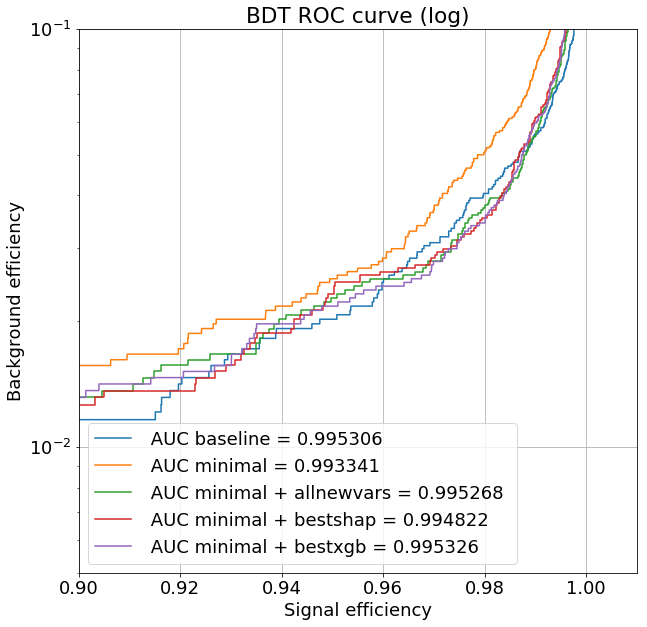

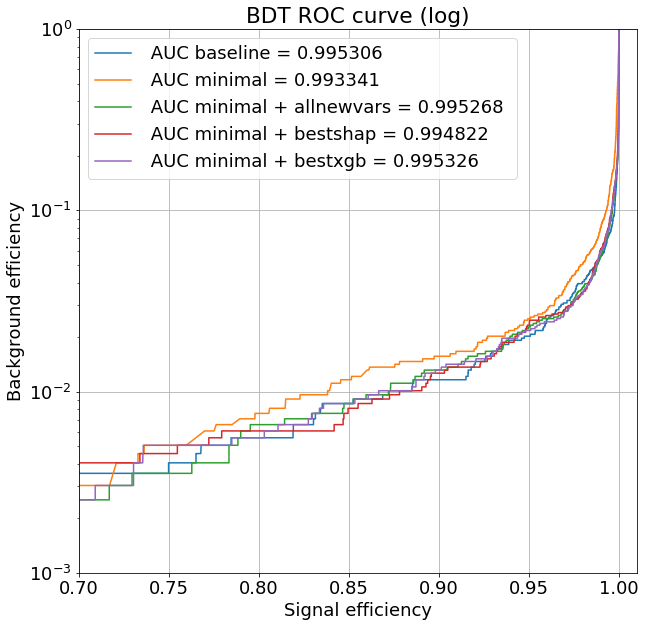

In [36]:
#plot roc curves
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
roc_test={}
roc={}
for i in BDT_list:
    bdt=BDT_list[i]


    fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),y_test[bdt['name']], pos_label=1, sample_weight=y_test['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc_test = auc(fpr, tpr)
    roc_test[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    print(bdt['name'])
    print ("AUC Score (Test): {:4%}".format(roc_auc_test))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(bdt['name'], roc_auc_test))
    plt.yscale('log')
    plt.xlim(0.9,1.01)
    plt.ylim(5e-3, 1e-1)
    
 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROCzoom_{}.png'.format(bkg))

plt.figure(figsize=(10,10))
roc_test={}
for i in BDT_list:
    bdt=BDT_list[i]


    fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),y_test[bdt['name']], pos_label=1, sample_weight=y_test['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc_test = auc(fpr, tpr)
    roc_test[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    #print(bdt['name'])
    #print ("AUC Score (Test): {:4%}".format(roc_auc_test))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(bdt['name'], roc_auc_test))
    plt.yscale('log')
    plt.xlim(0.7,1.01)
    plt.ylim(1e-3, 1e-0)
    fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y[bdt['name']], pos_label=1, sample_weight=y['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc= auc(fpr, tpr)
    roc[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})

 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROC_{}.png'.format(bkg))

In [15]:
bkg

'PU'

In [25]:
# calc BDT cut
BDT_cut={}
thr=0.95

for i in BDT_list:
    BDT_cut[i]=np.interp(thr,roc_test[i]['tpr'], roc_test[i]['threshold'])
    """with open(file_name, 'a') as f:
        f.write('BDT cut ={}  for tpr = {} and fpr {}\n'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']), np.interp(0.95,roc_test['tpr'], roc_test['tpr']), np.interp(0.95,roc_test['tpr'], roc_test['fpr'])))
"""
    print('BDT cut ={}  for tpr = {} and fpr {}'.format( np.interp(thr,roc_test[i]['tpr'], roc_test[i]['threshold']),
                                                        np.interp(thr,roc_test[i]['tpr'], roc_test[i]['tpr']),
                                                        np.interp(thr,roc_test[i]['tpr'], roc_test[i]['fpr'])))

BDT cut =0.5168683904050975  for tpr = 0.95 and fpr 0.020222446916076088
BDT cut =0.394315594681795  for tpr = 0.95 and fpr 0.025278058645095098
BDT cut =0.4562559296367022  for tpr = 0.95 and fpr 0.0227502527805856
BDT cut =0.47464206404106757  for tpr = 0.95 and fpr 0.0232558139534875
BDT cut =0.4665819346894266  for tpr = 0.95 and fpr 0.021739130434781796


In [26]:
#binning y_test


def calctp(group):
    pos=len(group[(group[column]>cutoff) & (group['signal']==1)])
    truepos= len(group[group['signal']==1])
    
    if truepos !=0 :return pos/truepos
    else : return np.nan
def calcfp(group):
    fp = len(group[(group[column]>cutoff) & (group['signal']==0)])
    trueneg = len(group[group['signal']==0])
    if trueneg !=0: return fp/trueneg
    else: return np.nan

In [27]:

#CALCULATE ERROR BARS
conf_level=0.67
from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi


In [28]:
BDT_list[i]['name']

'minimal + bestxgb'

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


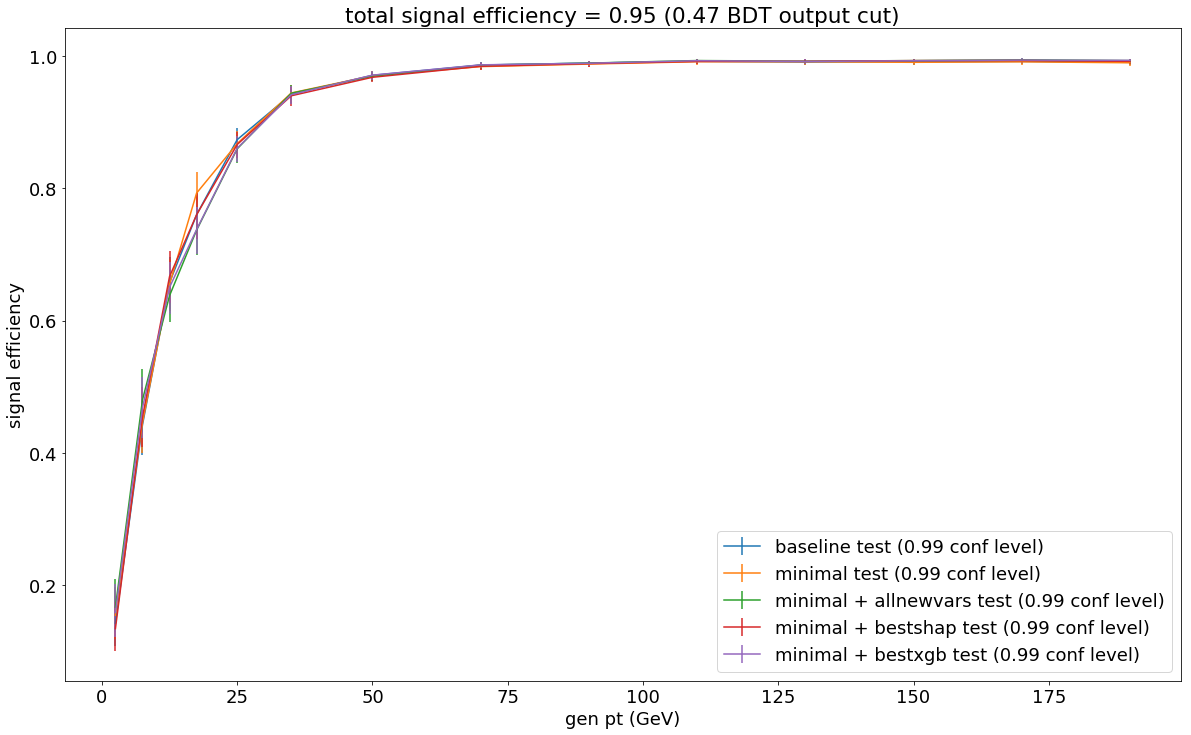

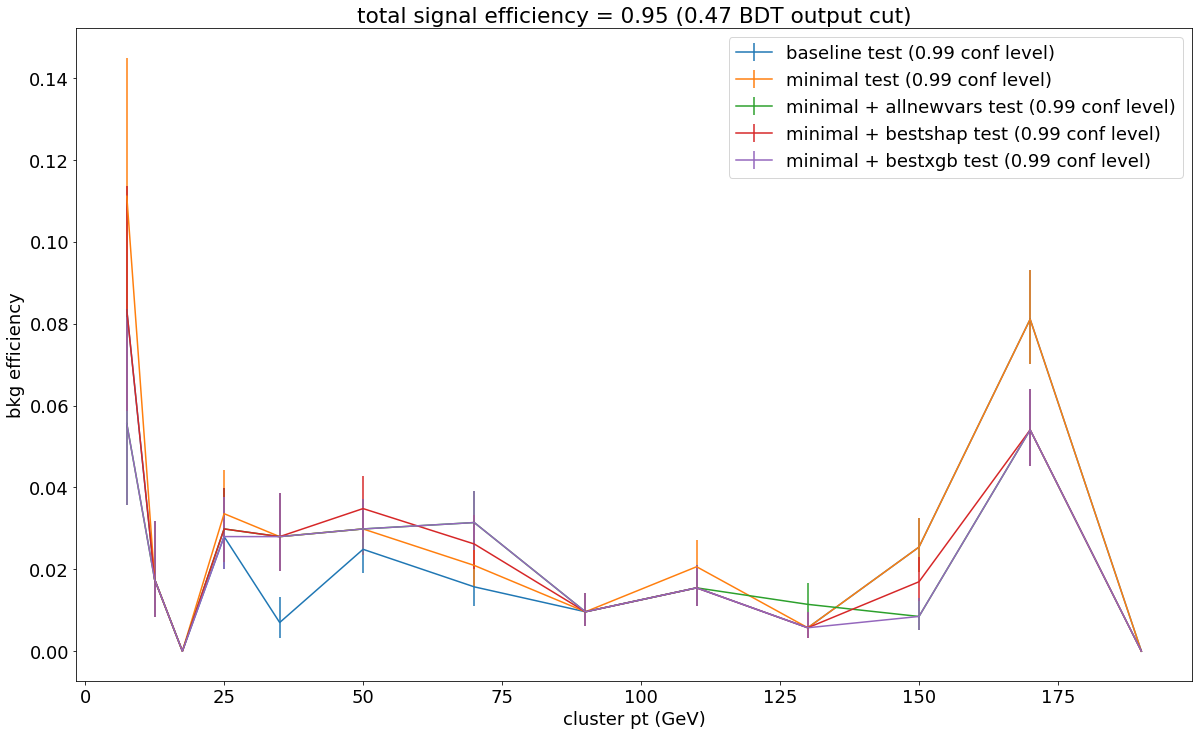

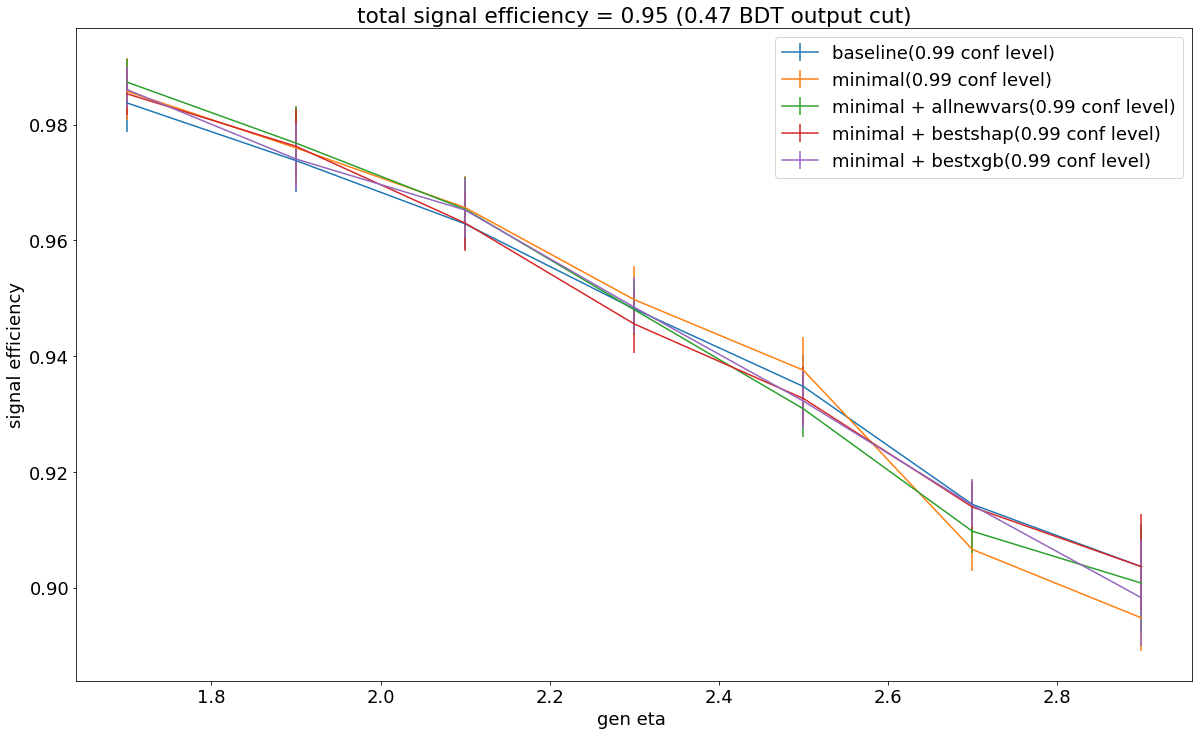

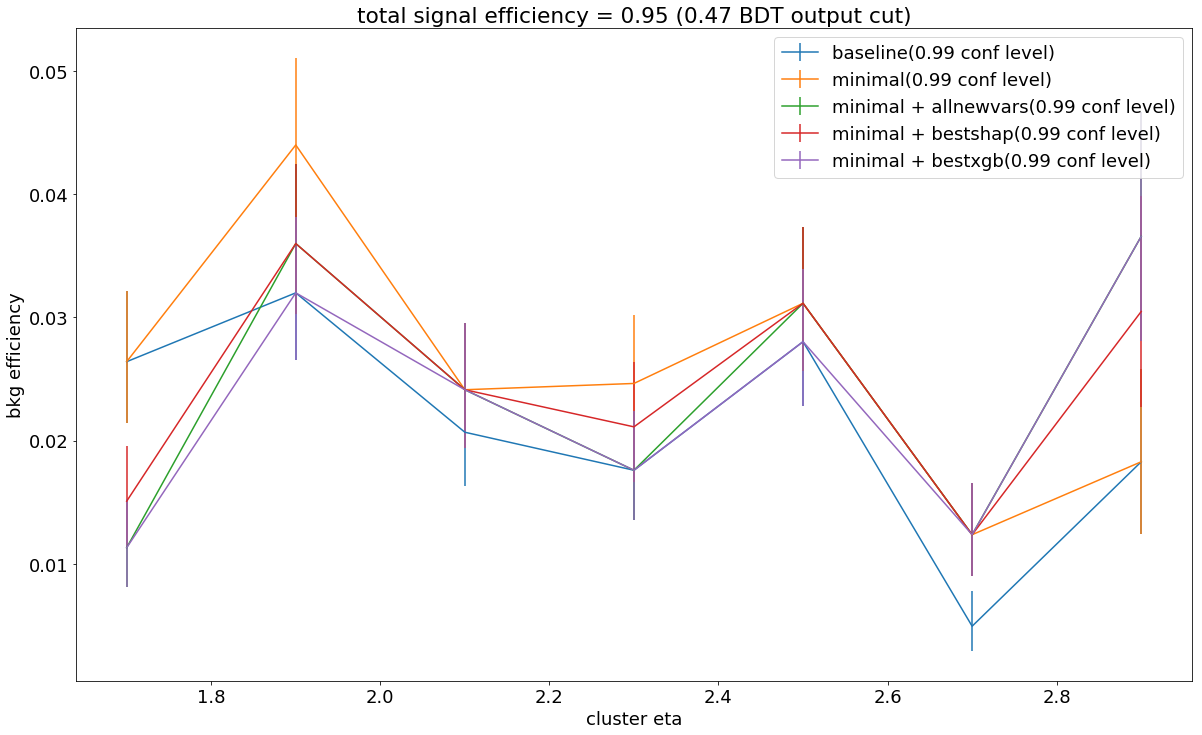

In [31]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
#y_test['BDT']=predictions_BDT_test

"""from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})"""

roc_cut_test={}
y_test['genpt_binned']=pd.cut(y_test['genpart_pt'], pt_bins)
y_test['cl3dpt_binned']=pd.cut(y_test['cl3d_pt'], pt_bins)
y_test['geneta_binned']=pd.cut(np.abs(y_test['genpart_exeta']), eta_bins)
y_test['cl3deta_binned']=pd.cut(np.abs(y_test['cl3d_eta']), eta_bins)

y_train['genpt_binned']=pd.cut(y_train['genpart_pt'], pt_bins)
y_train['cl3dpt_binned']=pd.cut(y_train['cl3d_pt'], pt_bins)
y_train['geneta_binned']=pd.cut(np.abs(y_train['genpart_exeta']), eta_bins)
y_train['cl3deta_binned']=pd.cut(np.abs(y_train['cl3d_eta']), eta_bins)


plt.figure(figsize=(20,12))
for i in BDT_list:
    roc_cut_test[i]=roc_test[i][roc_test[i]['tpr']>thr];

    conf_level=0.99

    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} test ({} conf level)'.format(column,conf_level))
"""    
    group=y_train.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_train.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} train ({} conf level)'.format(column,conf_level))
    """
plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}_{}.png'.format(thr, bkg))
    
plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} test ({} conf level)'.format(column, conf_level))
"""   
    group=y_train.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_train.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} train ({} conf level)'.format(column, conf_level))
    """
plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}_{}.png'.format(thr, bkg))


plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('geneta_binned').size(), fpr, conf_level)

    plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column,conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}_{}.png'.format(thr, bkg))

plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('cl3deta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('cl3deta_binned').size(), fpr, conf_level)
    plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column, conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}_{}.png'.format(thr, bkg))


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

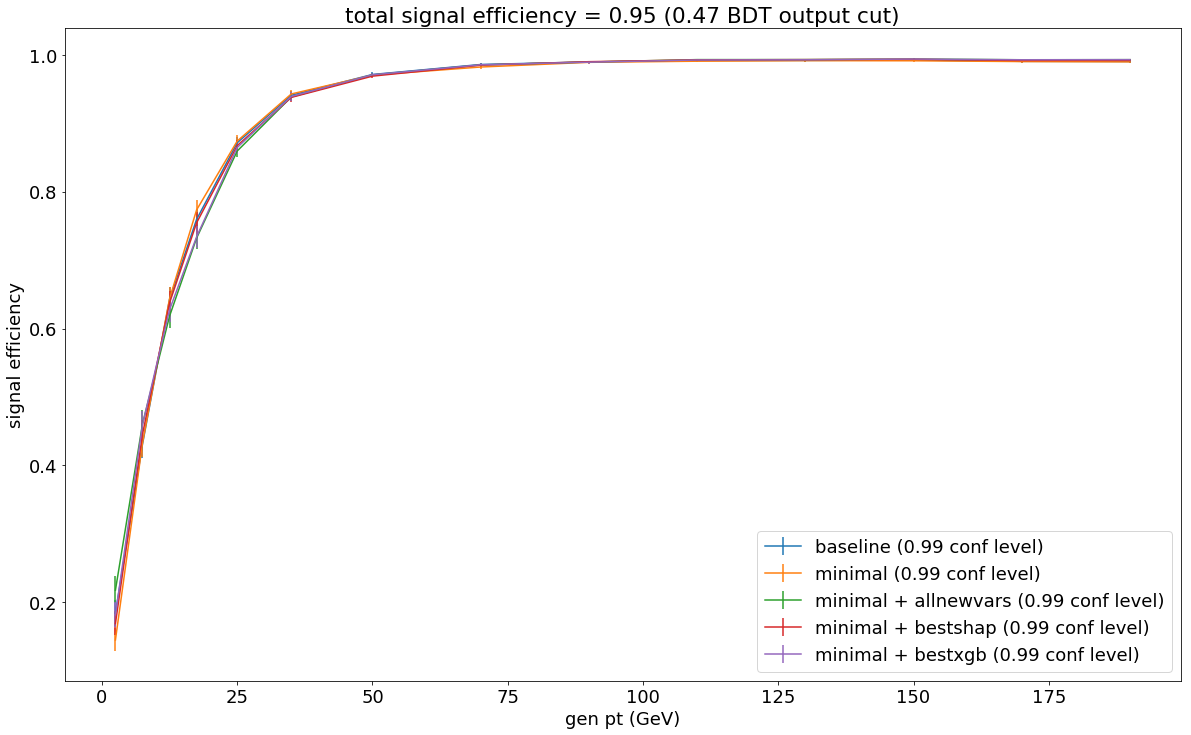

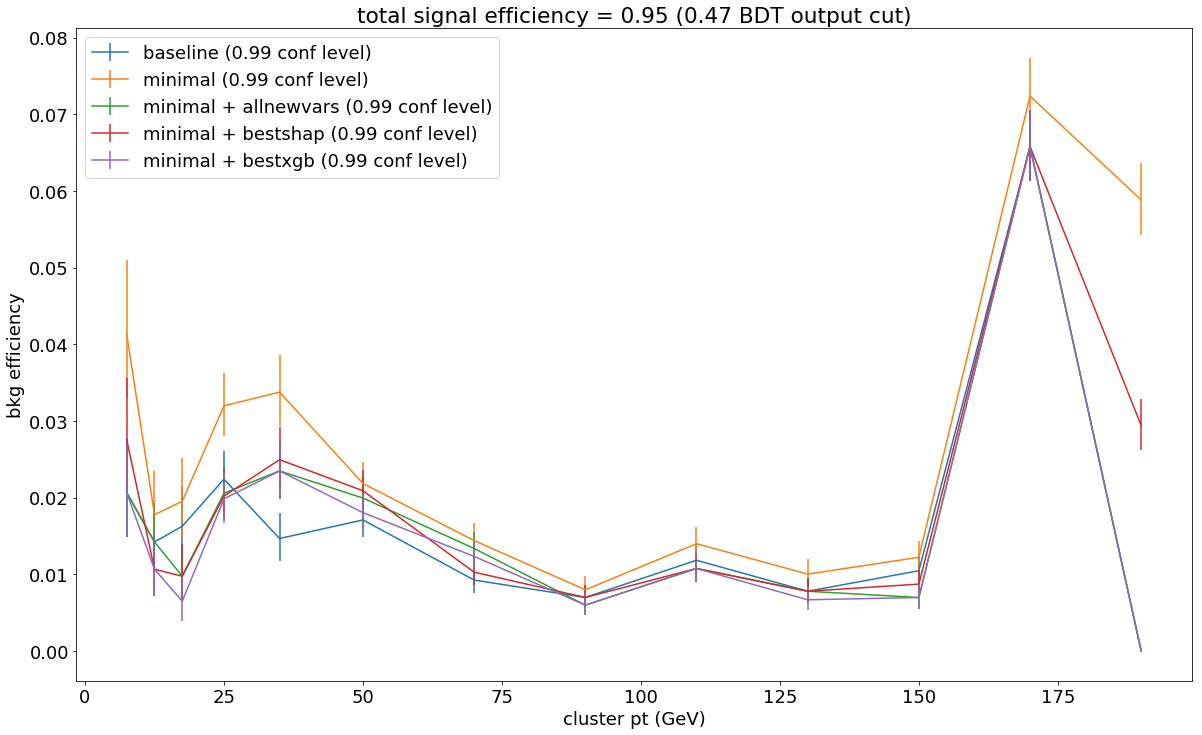

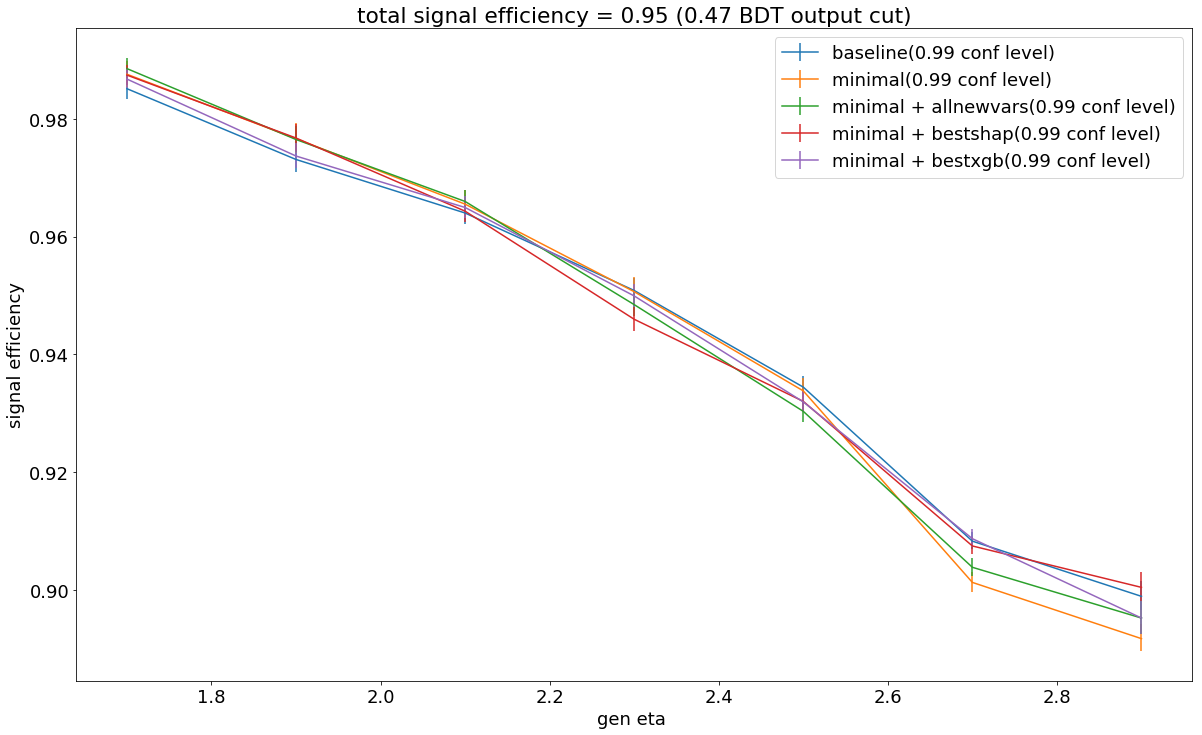

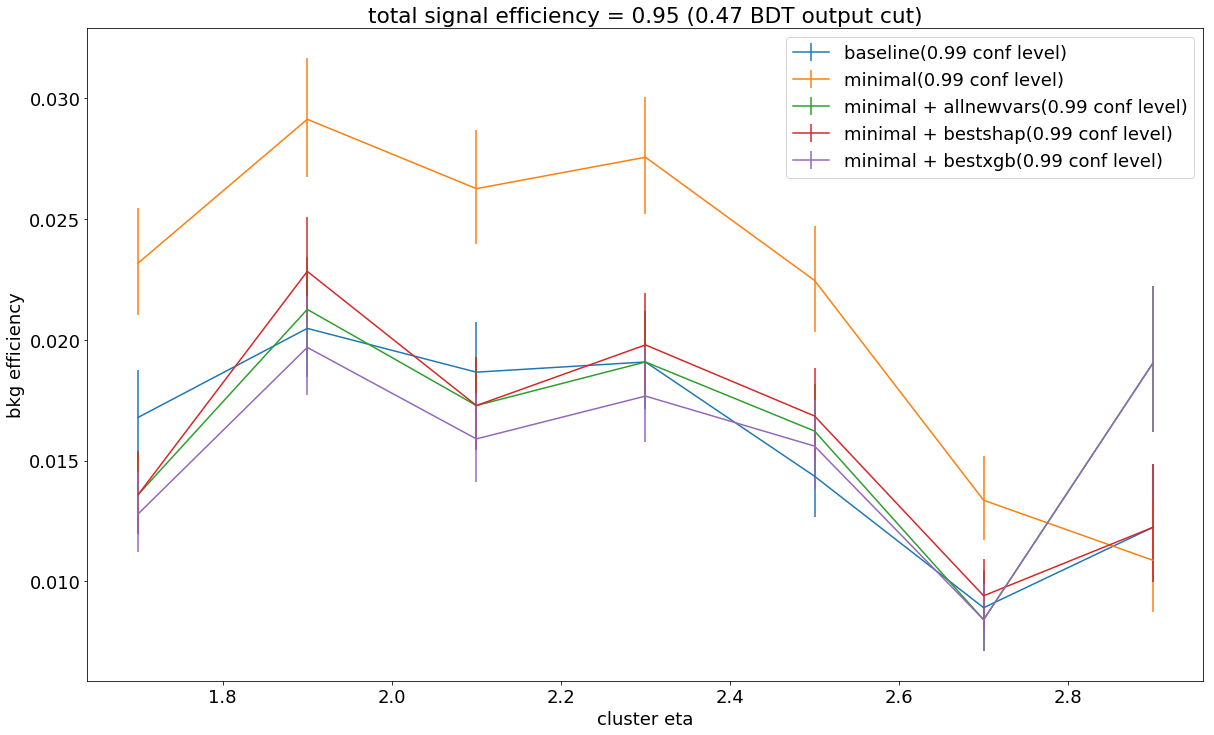

In [37]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
#y_test['BDT']=predictions_BDT_test

"""from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})"""

roc_cut={}
y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
y['cl3dpt_binned']=pd.cut(y['cl3d_pt'], pt_bins)
y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
y['cl3deta_binned']=pd.cut(np.abs(y['cl3d_eta']), eta_bins)


plt.figure(figsize=(20,12))
for i in BDT_list:
    roc_cut[i]=roc[i][roc[i]['tpr']>thr];

    conf_level=0.99

    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} ({} conf level)'.format(column,conf_level))

plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}_{}.png'.format(thr, bkg))
    
plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} ({} conf level)'.format(column, conf_level))

plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}_{}.png'.format(thr, bkg))


plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)

    plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column,conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}_{}.png'.format(thr, bkg))

plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('cl3deta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('cl3deta_binned').size(), fpr, conf_level)
    plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column, conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}_{}.png'.format(thr, bkg))


In [21]:
y_test.groupby('cl3dpt_binned').size()

cl3dpt_binned
(0, 5]           0
(5, 10]        836
(10, 15]      1090
(15, 20]      1207
(20, 30]      2868
(30, 40]      2476
(40, 60]      4975
(60, 80]      4817
(80, 100]     4928
(100, 120]    4831
(120, 140]    4644
(140, 160]    4708
(160, 180]    4582
(180, 200]    3962
(200, 220]     902
dtype: int64

#res pion BDT
AUC Score (Test): 99.770155%
AUC Score (Train): 99.903230%
background rejection test = 0.9882920110192837, train = 0.994824909435915
#res PU BDT
AUC Score (Test): 99.901765%
AUC Score (Train): 99.914897%
background rejection test = 0.9994748699879739, train = 0.9995563555778215

In [22]:
df_cut.columns

Index(['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta',
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample',
       'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3',
       'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9',
       'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15',
       'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21',
       'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27',
       'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33',
       'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT',
       'first_1', 'first_2', 'f